In [1]:
#Active environment should be cgcnn_matai
!conda info | grep 'cgcnn_matai'

     active environment : cgcnn_matai
    active env location : /home/hassan101/anaconda3/envs/cgcnn_matai


In [2]:
import pandas as pd
import json
import boto3
import io
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
MAPI_KEY = os.environ['MAPI_KEY']
aws_akid = os.environ['AWS_KID']
aws_sak = os.environ['AWS_AK']

## Loading data

In [4]:
res_s3 = boto3.resource('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak)
client_s3 = boto3.client('s3', aws_access_key_id=aws_akid, aws_secret_access_key= aws_sak) 

bucket_name = 'datasets-cgcnn'

def load_from_s3(file_path):
    response = client_s3.get_object(Bucket=bucket_name, Key=file_path).get("Body")
    print("FILE LOADED")
    return response

In [5]:
df_ds1 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds1.xlsx').read())).dropna(how='any').reset_index(drop=True)
df_ds2 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds2.xlsx').read())).dropna(how='any').reset_index(drop=True)
df_ds3 = pd.read_excel(io.BytesIO(load_from_s3('processed/processed_ds3.xlsx').read())).dropna(how='any').reset_index(drop=True)

FILE LOADED
FILE LOADED
FILE LOADED


## Further checks on materials

This snippet will check what materials in our datasets are likely to exit only in theoretical calculations

In [ ]:
from helper_funcs import check_icsd
df_ds1 = check_icsd(df_ds1)
df_ds2 = check_icsd(df_ds2)
df_ds3 = check_icsd(df_ds3)

theoretical = pd.DataFrame({'DS1': df_ds1.theoretical_only.value_counts(),'DS2': df_ds2.theoretical_only.value_counts(), 'DS3': df_ds3.theoretical_only.value_counts()  }  )
theoretical.at['ICSD_listed_%','DS1'] = theoretical.loc[0][0]/len(df_ds1)*100
theoretical.at['ICSD_listed_%','DS2'] = theoretical.loc[0][1]/len(df_ds2)*100
theoretical.at['ICSD_listed_%','DS3'] = theoretical.loc[0][2]/len(df_ds3)*100
theoretical.to_excel('ICSD_listed.xlsx')

Adding anion type to datasets

In [6]:
from helper_funcs import add_anions_v2
df_ds1 = add_anions_v2(df_ds1)
df_ds2 = add_anions_v2(df_ds2)
df_ds3 = add_anions_v2(df_ds3)

## Plotting distributions

In [7]:
def plot_bg(df, col_on_x, x_lab, title): 
    def name_of_var (variable):
        return [name for name in globals() if globals()[name] is variable][0]
    ax = sns.displot(df, x=col_on_x, kde=False)
    ax.set(xlabel=x_lab, ylabel='Count')
    plt.xticks(rotation=90)
    plt.title(title)
    plt.tight_layout()
    #plt.savefig('plots/Dist_{}_{}.jpeg'.format(name_of_var(df), col_on_x), dpi=300)  
    plt.show()
    #plt.close('all')
    return

Plotting band gap distributions

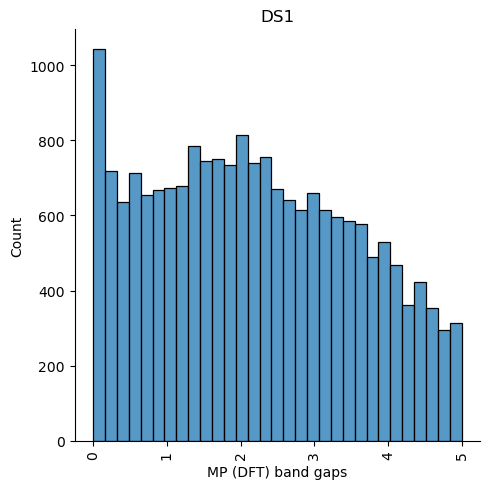

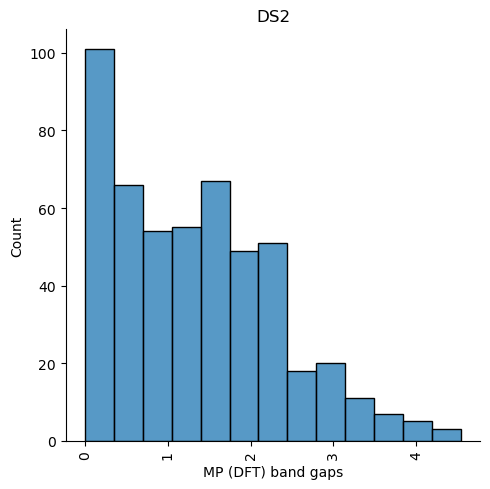

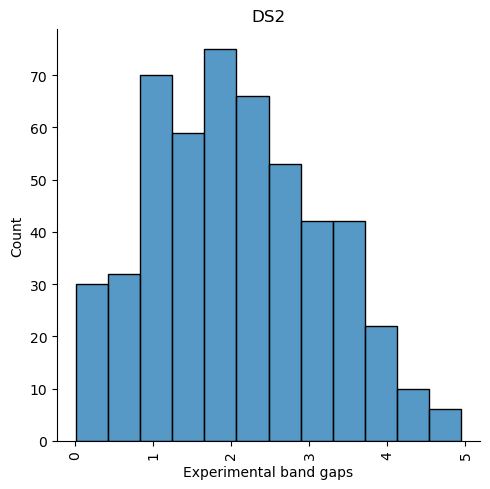

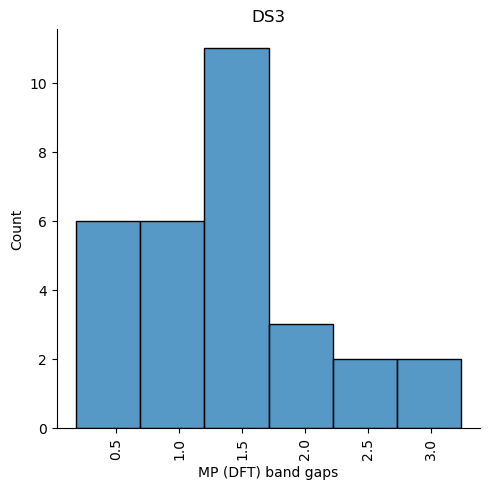

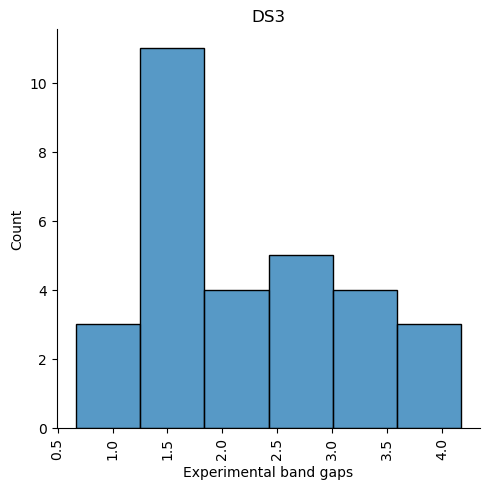

In [8]:
plot_bg(df_ds1, 'bg_mp', 'MP (DFT) band gaps', title='DS1')
plot_bg(df_ds2, 'bg_mp', 'MP (DFT) band gaps',title='DS2')
plot_bg(df_ds2, 'bg_exp', 'Experimental band gaps',title='DS2')
plot_bg(df_ds3, 'bg_mp', 'MP (DFT) band gaps',title='DS3')
plot_bg(df_ds3, 'bg_exp', 'Experimental band gaps',title='DS3')

Plotting distribution of material types in datasets

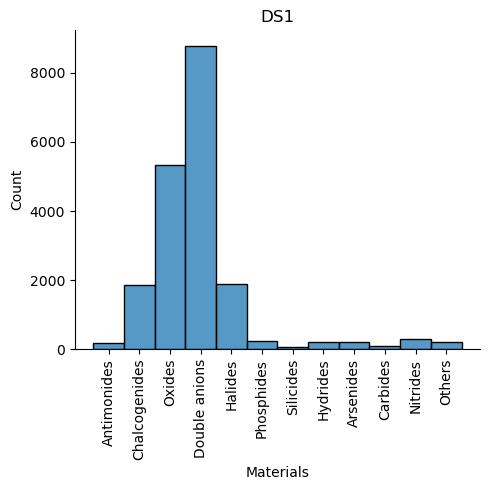

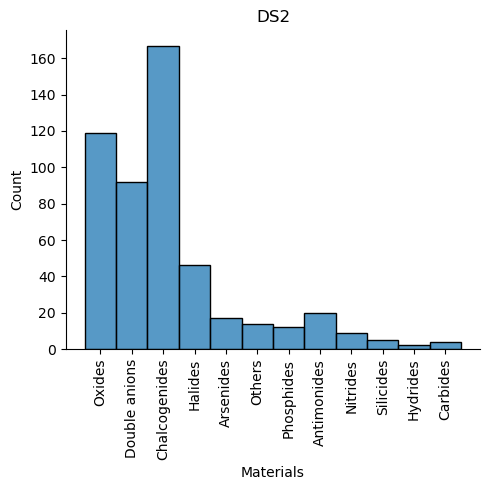

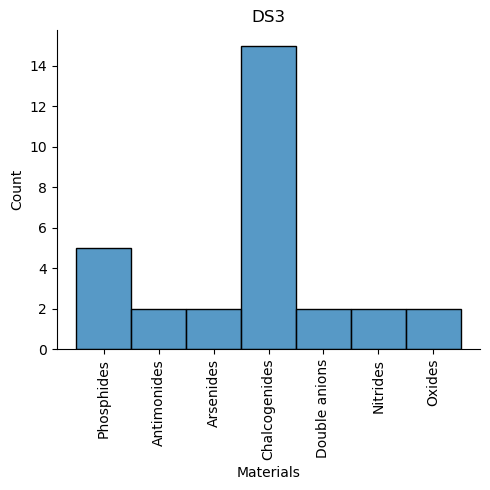

In [9]:
plot_bg(df_ds1, 'mat_type', 'Materials', title='DS1')
plot_bg(df_ds2, 'mat_type', 'Materials',title='DS2')
plot_bg(df_ds3, 'mat_type', 'Materials',title='DS3')


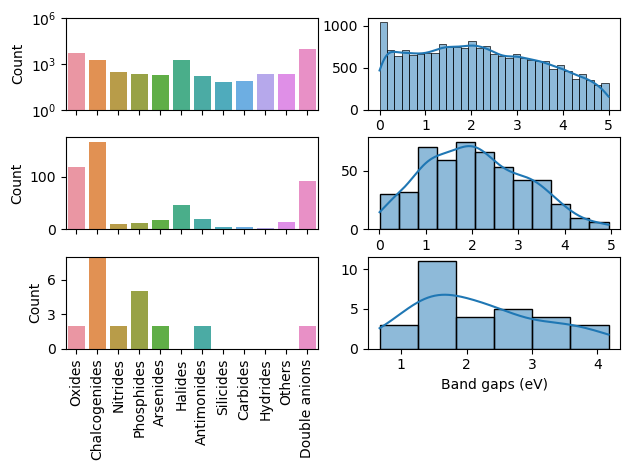

In [10]:
from plotter_funcs import plot_main_v2

plot_main_v2(df_ds1, df_ds2, df_ds3,
          save=False)

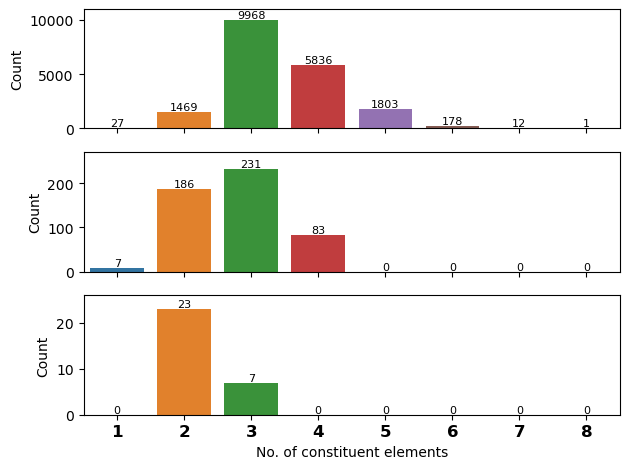

In [11]:
from plotter_funcs import plot_no_of_elements
plot_no_of_elements(df_ds1, df_ds2, df_ds3,
                    save=False)

## Combining the datasets

In [15]:
df_col = pd.DataFrame()
df_col['mats']= pd.concat([df_ds1['mat_type'],df_ds2['mat_type'], df_ds3['mat_type']]).reset_index(drop=True) 
df_col['bgs']= pd.concat([df_ds1['bg_mp'],df_ds2['bg_exp'], df_ds3['bg_exp']]).reset_index(drop=True) 

df_col['dataset'] = pd.DataFrame(
    pd.concat([ pd.DataFrame(['m1' for i in range(len(df_ds1))]),
               pd.DataFrame(['m2' for i in range(len(df_ds2))]),
               pd.DataFrame(['val' for i in range(len(df_ds3))])
              ]).reset_index(drop=True)
    )
df_col.head(10)

,mats,bgs,dataset
0,Antimonides,1.0760,m1
1,Chalcogenides,1.0256,m1
2,Chalcogenides,0.1100,m1
3,Oxides,2.6851,m1
4,Oxides,3.4273,m1
5,Double anions,3.5667,m1
6,Oxides,1.3036,m1
7,Oxides,0.1081,m1
8,Antimonides,0.2936,m1
9,Halides,4.2403,m1
